# Vortex Profile

This notebook shows
- how to fit a vortex profile obtained from LiDAR measurement
- how to calculate the core radius (size) and the total circulation (strength) of the vortex

### Import libraries

In [1]:
import random
from math import pi, sqrt

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.optimize import curve_fit
import scipy.integrate as integrate

from sklearn.metrics import mean_squared_error

## Vortex models

There are several ways to model a 2D vortex. 

### Lamb-Oseen model

https://en.wikipedia.org/wiki/Lamb%E2%80%93Oseen_vortex

Here, we are interested in the form of the Lamb-Oseen model for wake vortices:

$V(r) = \frac{\Gamma} {2 {\pi}} (1 - exp(-1.256\frac{r^2}{r_c^2}))$

where:
- ${\Gamma}$ is the total circulation
- ${r}$ is the distance from the vortex center or radial distance
- ${r_c}$ is the mean vortex core radius, i.e. the half of distance between velocity peaks
- ${V(r)}$ is the tangential velocity a r

In [2]:
def lamb_oseen(gamma, rc, r):
    """
    gamma: circulation in m^2/s
    rc: core_radius in m
    r: radial distance in m
    ---
    returns the tangential velocity
    """
    # Small manipulation to avoid the case r = 0 below 
    r_new = (r == 0).astype(int) / 1000 + r
    return gamma / (2 * pi * r_new) * (1 - np.exp( - 1.256 * r ** 2 / rc ** 2))

### Rankine model

https://en.wikipedia.org/wiki/Rankine_vortex

The drawback the rankine model is its non-linearity. Therefore it won't be used.

$V(r) = \frac{\Gamma r}{2 {\pi} r_c^2} $ for $r \le R $

$V(r) = \frac{\Gamma}{2 {\pi} r} $ if $ for > R $


where:
- ${\Gamma}$ is the total circulation
- ${r}$ is the distance from the vortex center or radial distance
- ${r_c}$ is the mean vortex core size, i.e. the half of distance between velocity peaks
- ${V(r)}$ is the tangential velocity a r

In [3]:
def rankine(gamma, rc, r):
    """
    gamma: circulation in m^2/s
    rc: core_radius in m
    r: radial distance in m
    ---
    returns the tangential velocity
    """
    internal_V = (abs(r) <= rc).astype(int) * gamma * r /( 2 * pi * rc**2)
    # Small manipulation to avoid the case r = 0 below 
    r_new = (r == 0).astype(int) / 1000 + r
    external_V = (abs(r) > rc).astype(int) * gamma / (2 * pi * r_new)
    return internal_V + external_V

### Burnham-Hallock model

The Burnham-Hallock model is widely used to model aircraft wake vortices.

$V(r)=\frac{\Gamma}{2{\pi}r}\frac{r^2}{r^2+r_c^2}$

where:
- ${\Gamma}$ is the total circulation
- ${r}$ is the distance from the vortex center or radial distance
- ${r_c}$ is the mean vortex core radius, i.e. the half of distance between velocity peaks
- ${V(r)}$ is the tangential velocity a r

In [4]:
def burnham_hallock(gamma, rc, r):
    """
    gamma: circulation in m^2/s
    rc: core_radius in m
    r: radial distance in m
    ---
    returns the tangential velocity
    """
    return gamma / (2 * pi) * r / (r ** 2 + rc ** 2)

### Comparison of the models

Let's define a vortex with 300m^2/s total circulation and a core radius of 4m between -20m and 20m and plot the vortex profile

In [5]:
r_max = 20
r_min = -r_max
r_step = 0.5

total_circulation = 300
core_radius = 4

radial_distance = np.arange(r_min, r_max+r_step, r_step)

velocity_lo = lamb_oseen(total_circulation, core_radius, radial_distance)
velocity_ra = rankine(total_circulation, core_radius, radial_distance)
velocity_bh = burnham_hallock(total_circulation, core_radius, radial_distance)

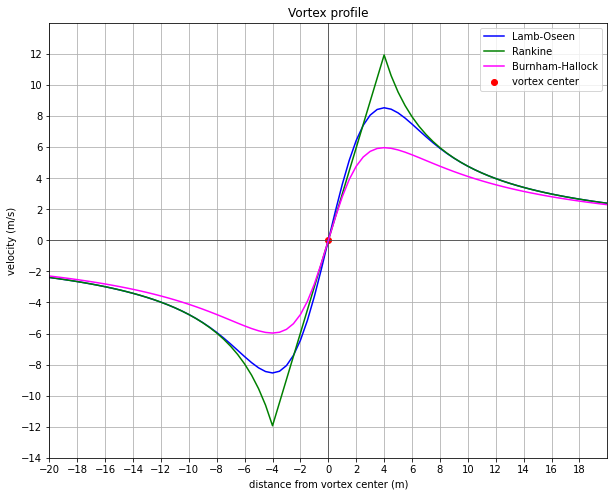

In [6]:
%matplotlib inline

y_max = int(max(np.max(velocity_lo), np.max(velocity_ra), np.max(velocity_bh)) / 2) * 2 + 4
x_max = r_max

fig, ax = plt.subplots(figsize=(10, 8))

xticks = np.arange(-x_max, x_max, 2)
yticks = np.arange(-y_max, y_max, 2)

plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.scatter([0],[0], color='red', label='vortex center')

ax.plot(radial_distance, velocity_lo, color='blue', label='Lamb-Oseen')
ax.plot(radial_distance, velocity_ra, color='green', label='Rankine')
ax.plot(radial_distance, velocity_bh, color='magenta', label='Burnham-Hallock')

ax.set(xlabel='distance from vortex center (m)', ylabel='velocity (m/s)', title='Vortex profile')
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.xlim(-x_max, x_max)
plt.ylim(-y_max, y_max)

plt.grid(b=True)

fig.savefig("./images/comparison_of_vortex_profiles.png")
plt.legend()
plt.show()

## Reconstruction of a LiDAR envelope

The analysis of aircraft wake vortices is made using data provided by post-processing of LiDAR measurements. These data consist of envelopes of the measured tangential velocity as a function of the radial distance (distance from the position of the vortex center).

To make the data more realistic, following additional parameters must be added to the model equations:
- random background noise
- radial shift $\Delta r_c$
- tangential velocity shift $\Delta V$
- random error around the calculted profile $\delta \epsilon_V$

The measurements are discrete, that means, that we obtained points on the velocity profile at a regular interval, the so-called LiDAR resolution.

In [7]:
def add_noise_to_envelope(velocity):
    """
    velocity: velocity profile (envelope) as a numpy array
    ---
    Add noise to the envelope.
    Noise is assumed to be 2 m/s
    The envelope is crossing the axis y = 0 (tangential velocity = 0) only in the core
    """
    noise = np.random.normal(1, 0.25, velocity.shape) * np.sign(velocity)
    return np.maximum(np.abs(velocity), noise) * np.sign(velocity)

In [8]:
def add_shift():
    """
    Returns two random numbers for radial and velocity shift
    """
    return random.gauss(0, 0.25), random.gauss(0, 0.25)

In [9]:
def add_random_error(velocity):
    """
    velocity: velocity profile (envelope) as a numpy array
    ---
    Add random error to the velocity profile
    An error of +/- 0.5 m/s is added to the profile
    """
    return velocity + np.random.normal(0, 0.25, velocity.shape)

In [10]:
def generate_lidar_envelope(Gamma, rc, r, model=burnham_hallock):
    """
    gamma: circulation in m^2/s
    rc: core_radius in m
    r: radial distance in m
    model: vortex model among burnham-hallock, lamb_oseen and rankine
    ---
    Return the full vortex profile including noise, shifts and error
    """
    Delta_r, Delta_V = add_shift()
    # radial shift
    r -= Delta_r
    # Velocity profile
    velocity_profile = model(Gamma, rc, r)
    # add the noise
    velocity_profile = add_noise_to_envelope(velocity_profile)
    # add the random_error
    velocity_profile = add_random_error(velocity_profile)
    # Tangential velocity shift
    return velocity_profile + Delta_V, Delta_r, Delta_V

In [11]:
def set_lidar_resolution():
    """
    Return the lidar resolution, i.e. the average radial distance between two data points
    """
    return random.uniform(1, 3)

Let's define a vortex with 300m^2/s total circulation and a core radius of 3m between -100m and 100m and plot the vortex profile with the LiDAR envelope.

For this exercise, we use a Burnham-Hallock profile.

In [12]:
r_max = 100
r_min = -r_max
r_step = set_lidar_resolution()

total_circulation = 300
core_radius = 4

radial_distance = np.arange(r_min, r_max+r_step, r_step)
radial_distance_model = np.arange(r_min, r_max+1, 0.5)

velocity_lidar, Delta_r, Delta_V = generate_lidar_envelope(total_circulation, core_radius, radial_distance)
velocity_model = burnham_hallock(total_circulation, core_radius, radial_distance_model)

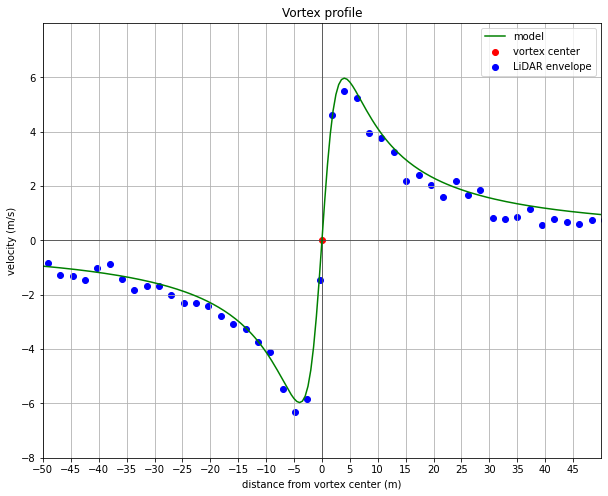

In [13]:
%matplotlib inline

y_max = int(max(velocity_lidar) / 2) * 2 + 4
x_max = 50

fig, ax = plt.subplots(figsize=(10, 8))

xticks = np.arange(-x_max, x_max, 5)
yticks = np.arange(-y_max, y_max, 2)

plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.scatter([0],[0], color='red', label='vortex center')

ax.scatter(radial_distance, velocity_lidar, color='blue', label='LiDAR envelope')
ax.plot(radial_distance_model, velocity_model, color='green', label='model')

ax.set(xlabel='distance from vortex center (m)', ylabel='velocity (m/s)', title='Vortex profile')
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.xlim(-x_max, x_max)
plt.ylim(-y_max, y_max)

plt.grid(b=True)

fig.savefig("./images/single_lidar_envelope.png")
plt.legend()
plt.show()

## Fitting of the LiDAR profile

The current step consists in doing the other way: from the reconstructed LiDAR profile, we will fit the data to estimate the original vortex characteristics

The adapted Burnham-Hallock model fitting the reconstructed data or the vortex profile data obtained from the LiDAR processing looks like:

$V(r)=\frac{\Gamma}{2{\pi}(r-\Delta r_c)}\frac{(r-\Delta r_c)^2}{(r-\Delta r_c)^2+r_c^2} + \Delta V$ 

Therefore, there are 4 unknown for this equation:
- $\Gamma$, the total circulation of the vortex
- $r_c$, the core radius of the vortex
- $\Delta r_c$, the radial shift
- $\Delta V$, the velocity shift

### Definition of the profile function as the modified Burnham-Hallock model

In [14]:
def modified_burnham_hallock(r, gamma, rc, delta_r, delta_V):
    """
    gamma: circulation in m^2/s
    rc: core_radius in m
    r: radial distance in m
    delta_r: radial shift in m
    delta_V: tangential velocity shift in m/s
    ---
    Returns the tangential velocity using the modified Burnham-Hallock model
    """
    return gamma / (2 * pi) * (r - delta_r) / ( (r - delta_r )** 2 + rc**2) + delta_V

### First estimation of the velocity peaks
The positions of the peak velocities are read from the LiDAR profile.

In [15]:
def get_min_max_index(velocity):
    """
    velocity: velocity profile (envelope) as a numpy array
    ---
    Returns the indices of the peak velocities
    """
    return np.argmin(velocity), np.argmax(velocity)

In [16]:
def get_min_max_radii(radial_distance, velocity):
    """
    velocity: velocity profile (envelope) as a numpy array
    ---
    Return the distance from the vortex center (r=0) for the peak velocities
    """
    idx_min, idx_max = get_min_max_index(velocity)
    return radial_distance[idx_min], radial_distance[idx_max]

In [17]:
def get_min_max_velocity(velocity):
    """
    velocity: velocity profile (envelope) as a numpy array
    ---
    Return the values of the peak velocities
    """
    return np.min(velocity), np.max(velocity)

### Estimation of the mean tangential velocities
The mean tangential velocity is the mean of the absolute velocity.

Positive and negative mean tangential velocities outside the vortex core are calculated separately.

In [18]:
def get_abs_mean_velocity(velocity):
    """
    velocity: velocity profile (envelope) as a numpy array
    ---
    Returns the average of absolute tangential velocities of the vortex profile
    """
    return np.mean(np.abs(velocity))

In [19]:
def get_neg_pos_mean_velocities(velocity):
    """
    velocity: velocity profile (envelope) as a numpy array
    ---
    Return the average of tangential velocities of the negative and positive vortex sides separately
    """
    idx_min, idx_max = get_min_max_index(velocity)
    return np.mean(velocity[:idx_min+1]), np.mean(velocity[idx_max:])

### Dismissing of outliers
#### Noise - Cuf-off
First, points far from the core are not to be separated from the noise. A cut-off is introduced under the following assumptions:
- Only a small of number of points is measured around the core,
- Their tangential velocities are bigger than the noise,
- In that case, the mean tangential velocity is slighty bigger than the envelope of the noise,
- Every point under the mean velocity may therefore be considered as an outlier and has to be dismissed,
- To avoid an early cut-off due to a single outlier, there must be at least 3 points in a row under the mean velocity to locate the cut-off position.
- Points at the limit of the window are considered to be noise.

Second, points inside the vortex core with tangential velocity smaller than the mean velocity are also dismissed as noise.

This method is used for positive and negative velocities separately.

In [20]:
def selection_of_points(velocity):
    """
    velocity: velocity profile (envelope) as a numpy array
    ---
    Returns the selected points for the data fitting
    """
    v_neg_mean, v_pos_mean = get_neg_pos_mean_velocities(velocity)
    idx_min, idx_max = get_min_max_index(velocity)
    
    # negative envelope
    selected_neg_points = np.append(np.zeros(1), [(velocity[i-1] <= v_neg_mean).astype(int) +
                                                  (velocity[i] <= v_neg_mean).astype(int) + 
                                                  (velocity[i+1] <= v_neg_mean).astype(int) 
                                                  for i in range(1, len(velocity)-1)])
    selected_neg_points = np.append(selected_neg_points, np.zeros(1))
    
    # positive envelope
    selected_pos_points = np.append(np.zeros(1), [(velocity[i-1] >= v_pos_mean).astype(int) +
                                                  (velocity[i] >= v_pos_mean).astype(int) + 
                                                  (velocity[i+1] >= v_pos_mean).astype(int) 
                                                  for i in range(1, len(velocity)-1)])
    selected_pos_points = np.append(selected_pos_points, np.zeros(1))
    
    # Selected points in the vortex core
    selected_core_points = np.concatenate((np.ones(idx_min), 
                                           np.abs(velocity[idx_min:idx_max]) >= 
                                               0.5 * (v_pos_mean - v_neg_mean), 
                                           np.ones(velocity.shape - idx_max)))
    
    return (selected_neg_points + selected_pos_points) * selected_core_points
    # return 1

In [21]:
def dismiss_values_from_profile(vector, selected_points, velocity):
    """
    vector: numpy array containing the velocity profile or radial distance
    selected_points: selected points for the data fitting
    velocity: velocity profile (envelope) as a numpy array
    ---
    Returns a reduced vector containing only data points used for the fitting
    """
    idx_min, idx_max = get_min_max_index(velocity)
    idx_core = np.where(selected_points[idx_min:idx_max] == 0)
    
    idx_start = np.where(selected_points[:idx_min] == 0)[0][-1]
    idx_end = np.where(selected_points[idx_max:] == 0)[0][0] + idx_max

    if idx_core[0].size == 0:
        return vector[idx_start:idx_end+1]
    
    idx_core_min = idx_core[0][0] + idx_min
    idx_core_max = idx_core[0][-1] + idx_min
    
    return np.concatenate((vector[idx_start:idx_core_min], vector[idx_core_max+1:idx_end+1]))

In [22]:
selected_points = selection_of_points(velocity_lidar)
distance_for_fitting = dismiss_values_from_profile(radial_distance, selected_points, velocity_lidar)
velocity_for_fitting = dismiss_values_from_profile(velocity_lidar, selected_points, velocity_lidar)

In [23]:
v_neg_mean, v_pos_mean = get_neg_pos_mean_velocities(velocity_lidar)

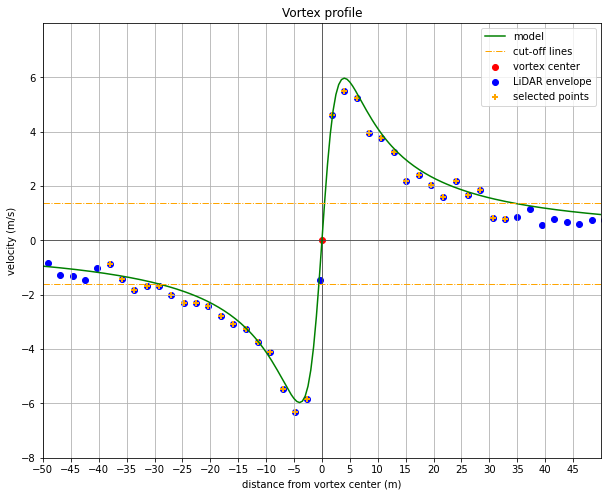

In [24]:
%matplotlib inline

y_max = int(max(velocity_lidar) / 2) * 2 + 4
x_max = 50

fig, ax = plt.subplots(figsize=(10, 8))

xticks = np.arange(-x_max, x_max, 5)
yticks = np.arange(-y_max, y_max, 2)

plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.scatter([0],[0], color='red', label='vortex center')

ax.scatter(radial_distance, velocity_lidar, color='blue', label='LiDAR envelope')
ax.scatter(distance_for_fitting, velocity_for_fitting, marker='+', color='orange', \
           lw=2, label='selected points')
ax.plot(radial_distance_model, velocity_model, color='green', label='model')

plt.axhline(v_neg_mean, color='orange', lw=1, ls='-.', label='cut-off lines')
plt.axhline(v_pos_mean, color='orange', lw=1, ls='-.')

ax.set(xlabel='distance from vortex center (m)', ylabel='velocity (m/s)', title='Vortex profile')
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.xlim(-x_max, x_max)
plt.ylim(-y_max, y_max)

plt.grid(b=True)

fig.savefig("./images/single_lidar_envelope_with_selected_points.png")
plt.legend()
plt.show()

### Fit the LiDAR profile with the built-in function curve_fit

In [25]:
fitted_values, pcov = curve_fit(modified_burnham_hallock, 
                                distance_for_fitting, 
                                velocity_for_fitting, 
                                p0 = [100,1,0,0])

#### Comparison of results with initial data

In [26]:
original_values = [total_circulation, core_radius, Delta_r, Delta_V]

comparison_table = pd.DataFrame({'Original': original_values, 'Fit': fitted_values, 
                                 'Error': original_values - fitted_values,
                                 'Rel. error': 100 * (original_values - fitted_values) / original_values},
                                index=['Total circulation', 'Core radius', 'Delta_r', 'Delta_V'])

comparison_table.round(2)

,Original,Fit,Error,Rel. error
Total circulation,300.00,288.40,11.60,3.87
Core radius,4.00,3.81,0.19,4.74
Delta_r,0.05,-0.10,0.15,276.10
Delta_V,-0.25,-0.23,-0.02,7.67


Based on these original values, core radius and total circulation are well estimated.

In [27]:
def root_mean_square_error(velocity_for_fitting, velocity_from_fitting):
    """
    velocity_for_fitting: numpy array containing the velocity profile before fitting
    velocity_from_fitting: numpy array containing the fitted velocity profile
    ---
    Returns the root-mean-square error of the fit
    """
    return sqrt(mean_squared_error(velocity_for_fitting, velocity_from_fitting))

In [28]:
velocity_from_fitting = modified_burnham_hallock(distance_for_fitting, 
                                                 total_circulation, 
                                                 core_radius, 
                                                 Delta_r, Delta_V)

RMSE = root_mean_square_error(velocity_for_fitting, velocity_from_fitting)

print(f"The root-mean-square error is {RMSE:0.3f} m/s")

The root-mean-square error is 0.281 m/s


#### Compare the original, reconstructed and fitted profile all together

In [29]:
velocity_from_fitting = modified_burnham_hallock(radial_distance_model, 
                                                 total_circulation, 
                                                 core_radius, 
                                                 Delta_r, Delta_V)

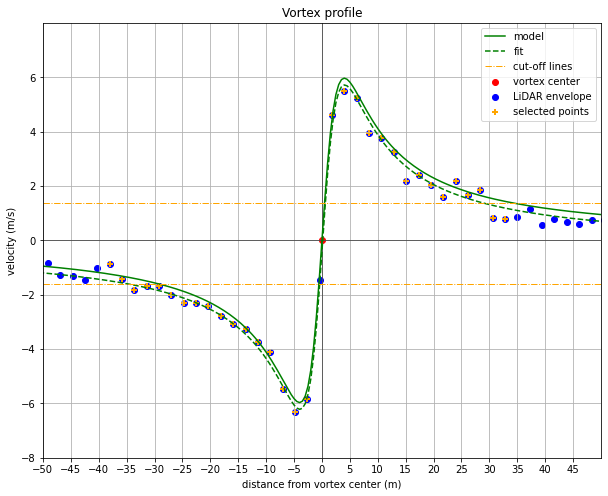

In [30]:
%matplotlib inline

y_max = int(max(velocity_lidar) / 2) * 2 + 4
x_max = 50

fig, ax = plt.subplots(figsize=(10, 8))

xticks = np.arange(-x_max, x_max, 5)
yticks = np.arange(-y_max, y_max, 2)

plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.scatter([0],[0], color='red', label='vortex center')

ax.scatter(radial_distance, velocity_lidar, color='blue', label='LiDAR envelope')
ax.scatter(distance_for_fitting, velocity_for_fitting, marker='+', color='orange', \
           lw=2, label='selected points')
ax.plot(radial_distance_model, velocity_model, color='green', label='model')
ax.plot(radial_distance_model, velocity_from_fitting, color='green', ls='--', label='fit')

plt.axhline(v_neg_mean, color='orange', lw=1, ls='-.', label='cut-off lines')
plt.axhline(v_pos_mean, color='orange', lw=1, ls='-.')

ax.set(xlabel='distance from vortex center (m)', ylabel='velocity (m/s)', title='Vortex profile')
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.xlim(-x_max, x_max)
plt.ylim(-y_max, y_max)

plt.grid(b=True)

fig.savefig("./images/single_lidar_envelope_with_fit.png")
plt.legend()
plt.show()

## Circulation between 5 to 15m
The circulation of a single vortex is a function of radial distance from the vortex center r and the tangential velocity V(r)

$\Gamma(r) = 2 \pi r V(r)$

In cases of wake vortex analysis the standardized circulation is the circulation calculated between 5 and 15m from the vortex center, i.e. the averaged integral within this range.

#### Integral form

In [31]:
def gamma5to15_full_integral(model, gamma, rc, a, b):
    """
    model: vortex model among burnham-hallock, lamb_oseen and rankine
    gamma: circulation in m^2/s
    rc: core_radius in m
    a: lower limit of integration
    b: upper limit of integration
    ---
    Returns the averaged integral of the circulation from a to b
    """
    return integrate.quad(lambda r: 2 * pi * r * model(gamma, rc, r), a, b)[0] / (b - a)

In [32]:
Gamma5to15_full = gamma5to15_full_integral(burnham_hallock, total_circulation, core_radius, 5, 15)

In [33]:
print(f"The circulation 5-15m for this vortex is {Gamma5to15_full:0.1f} m^2")
print(f"This represents {100*Gamma5to15_full/total_circulation:0.1f} % of the total circulation")

The circulation 5-15m for this vortex is 250.3 m^2
This represents 83.4 % of the total circulation


#### Discrete form

In [34]:
def gamma5to15_selection_of_points(radial_distance, velocity, a, b):
    """
    radial distance: distance from the vortex center as numpy array
    velocity: velocity profile (envelope) as a numpy array
    a: lower limit of integration
    b: upper limit of integration
    ---
    Returns the selected points between a and b    """
    preselected_r = radial_distance[np.abs(radial_distance) <= b]
    preselected_V = velocity[np.abs(radial_distance) <= b]
    
    selected_r = preselected_r[np.abs(preselected_r) >= a]
    selected_V = preselected_V[np.abs(preselected_r) >= a]

    return selected_r, selected_V

In [35]:
def gamma5to15_discrete_integral(radial_distance, velocity, a, b):
    """
    radial distance: distance from the vortex center as numpy array
    velocity: velocity profile (envelope) as a numpy array
    a: lower limit of integration
    b: upper limit of integration
    ---
    Returns the averaged circulation between a and b
    """
    selected_r, selected_V = gamma5to15_selection_of_points(radial_distance, velocity, a, b)
    return np.sum(2 * pi * selected_r * selected_V) / len(selected_r)

In [36]:
Gamma5to15_discrete = gamma5to15_discrete_integral(radial_distance, velocity_lidar, 5, 15)

In [37]:
print(f"The circulation 5-15m for this vortex is {Gamma5to15_discrete:0.1f} m^2")
print(f"This represents {100*Gamma5to15_discrete/total_circulation:0.1f} % of the total circulation")

The circulation 5-15m for this vortex is 246.0 m^2
This represents 82.0 % of the total circulation


#### Comparison of results with initial data

In [38]:
original_values = np.array([Gamma5to15_full])
fitted_values = np.array([Gamma5to15_discrete])

comparison_table = pd.DataFrame({'Original model': original_values, 'LiDAR': fitted_values, 
                                 'Error': original_values - fitted_values,
                                 'Rel. error': 100 * (original_values - fitted_values) / original_values},
                                index=['Circulation 5-15m'])

comparison_table.round(2)

,Original model,LiDAR,Error,Rel. error
Circulation 5-15m,250.3,245.97,4.33,1.73
